# **Paltas** (Taller/Evaluación 7)

Como sabemos, la palta es un probablemente uno de los mejores y más característicos productos de nuestra cultura (chilena). Afortunada o desafortunadamente, este sabroso alimento (fruta o verdura?) se ha vuelto también muy popular entre los jóvenes de otros países, especialmente entre aquellos denominados *millenials*, que suelen estar dispuestos a desembolsar cifras no despreciables por un ejemplar. En este taller trabajará con datos reales sobre la venta de paltas en uno de los mercados más relevantes para nuestro país.


![texto alternativo](https://i0.wp.com/pousta.com/wp-content/uploads/2018/05/palta.jpg?resize=930%2C525&ssl=1)



## Datos



Los datos con los que trabajará se encuentran en los archivos *paltas-usa-normales.csv* y *paltas-usa-organicas.csv* que corresponden a las ventas semanales de palta en estados unidos, entre 2017 y 2018. El primer registro considera paltas convencionales y el segundo aquellas que califican como orgánicas. Cada registro (fila) contiene atributos como: la fecha (Date) y ciudad (region) a la que corresponde el dato, el precio de venta (Price, valor promedio por unidad), y el número total de paltas vendidas (TotalVolume).



In [267]:
#Si carga los datos localmente no necesita ejecutar esta celda.
#Si los carga desde Drive, debe cambiar la ruta a la carpeta donde se encuentran. 

print("Mounting your Google Drive ...")

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=False)
 
path = "/content/drive/My Drive/Colab Notebooks/"#Esta es la ruta


Mounting your Google Drive ...
Mounted at /content/drive


In [268]:
import pandas as pd
import numpy as np

paltas_normales = pd.read_csv(path+'paltas-usa-normales.csv')
paltas_organicas = pd.read_csv(path+'paltas-usa-organicas.csv')
paltas_normales['month'] = paltas_normales['Date'].apply(lambda x: x.split('-')[1]).astype('int64')
paltas_organicas['month'] = paltas_organicas['Date'].apply(lambda x: x.split('-')[1]).astype('int64')

print(paltas_normales.head())
print(paltas_normales.columns)

print(paltas_organicas.head())
print(paltas_organicas.columns)



   Unnamed: 0        Date  region  ... Price      Prop  month
0        5616  2017-12-31  Albany  ...  1.47  0.970389     12
1        5617  2017-12-24  Albany  ...  1.45  0.954243     12
2        5618  2017-12-17  Albany  ...  1.43  0.952639     12
3        5619  2017-12-10  Albany  ...  1.29  0.960668     12
4        5620  2017-12-03  Albany  ...  1.39  0.975081     12

[5 rows x 12 columns]
Index(['Unnamed: 0', 'Date', 'region', 'type', '4046', '4225', '4770', 'year',
       'TotalVolume', 'Price', 'Prop', 'month'],
      dtype='object')
   Unnamed: 0        Date  region     type  ...  TotalVolume  Price      Prop  month
0       14741  2017-12-31  Albany  organic  ...      3463.85   1.46  0.029611     12
1       14742  2017-12-24  Albany  organic  ...      3694.13   1.58  0.045757     12
2       14743  2017-12-17  Albany  organic  ...      3513.77   1.43  0.047361     12
3       14744  2017-12-10  Albany  organic  ...      3779.98   1.45  0.039332     12
4       14745  2017-12-03  Alb

## Helpers (Funciones para Intervalos)


In [269]:
from scipy.stats import norm, t, chisquare, chi2
from scipy.stats import f as fisher

#para media
def IC_media(muestra,alpha=0.05):
    n = len(muestra)
    media_muestral = np.mean(muestra)
    std_muestral = np.std(muestra,ddof=1)
    return t.interval(1-alpha, df=n-1, loc=media_muestral, scale=std_muestral/np.sqrt(n))


#para media1-media2
def IC_dos_medias_hetero(muestra1, muestra2, alpha=0.05):
    n1 = len(muestra1); n2 = len(muestra2);
    media1 = np.mean(muestra1); media2 = np.mean(muestra2); 
    std1 = np.std(muestra1,ddof=1); std2 = np.std(muestra2,ddof=1); 
    gl_num = (std1**2/float(n1) + std2**2/float(n2))**2
    gl_den = ((std1**2/float(n1))**2)/(n1-1.0) + ((std2**2/float(n2))**2)/(n2-1.0)
    gl = int(np.floor(gl_num/gl_den))
    t_alpha = t.ppf(1-alpha/2.0,df=gl)
    std_error = np.sqrt(std1**2/n1 + std2**2/n2)
    #print(">>",gl,std_error,t_alpha)
    IC_inf = (media1-media2) - t_alpha * std_error
    IC_sup = (media1-media2) + t_alpha * std_error 
    return IC_inf,IC_sup

#para sigma1**2
def IC_varianza(muestra1, alpha=0.05):
    n1 = len(muestra1); 
    var1 = np.var(muestra1,ddof=1); 
    a = chi2.ppf(alpha/2.0,df=n1-1)
    b = chi2.ppf(1-alpha/2.0,df=n1-1)
    IC_inf = (n1-1)*var1/b
    IC_sup = (n1-1)*var1/a
    return IC_inf,IC_sup
    
#para sigma1**2/sigma2**2
def IC_dos_varianzas(muestra1, muestra2, alpha=0.05):
    n1 = len(muestra1); n2 = len(muestra2);
    var1 = np.var(muestra1,ddof=1); var2 = np.var(muestra2,ddof=1); 
    cuociente = var1/var2
    fa = 1.0/fisher.ppf(1-alpha/2.0,dfn=n1-1, dfd=n2-1)
    fb = fisher.ppf(1-alpha/2.0,dfn=n2-1, dfd=n1-1)
    IC_inf = fa*cuociente
    IC_sup = fb*cuociente
    return IC_inf,IC_sup

#para prop1
def IC_prop(n1,frac1,alpha=0.05):
    std_err = np.sqrt((frac1*(1.0-frac1)/n1))
    z_alpha = norm.ppf(1-alpha/2.0)
    IC_inf = frac1 - z_alpha * std_err 
    IC_sup = frac1 + z_alpha * std_err
    return IC_inf,IC_sup

#para prop1-prop2
def IC_dos_props(n1,n2,frac1,frac2, alpha=0.05):
    std_err = np.sqrt((frac1*(1.0-frac1)/n1) + (frac2*(1.0-frac2)/n2))
    z_alpha = norm.ppf(1-alpha/2.0)
    IC_inf = (frac1-frac2) - z_alpha * std_err 
    IC_sup = (frac1-frac2) + z_alpha * std_err
    return IC_inf,IC_sup

## **1:  Orgánicas versus Normales**

Dado que producir una palta siguiendo estándares que la hagan calificar como *orgánica* es más costoso, es interesante preguntarse si esto se traduce en un mayor margen de utilidad. 

> **¿Es mucho mayor el precio de una palta orgánica?**

Elabore una conclusión ejecutando las siguientes actividades:

1.   Construya sendos intervalos de confianza (I.C.) para el valor esperado del precio de la palta orgánica y normal. Adopte un nivel de confianza del 95%. Compare los intervalos y explique qué se puede concluir.

2.   Construya ahora un único I.C. que de cuenta de la diferencia de precio de ambas variedades. Razone sobre la magnitud de la diferencia de precios. Aumente gradualmente la confianza desde un 95% hasta un 99.999% para determinar si sus conclusiones son significativas. ¿Es sensato usar un I.C. del 100% de confianza?  

3.  Simule un escenario en que se dispone de sólo 1/10 de las observaciones de cada muestra. ¿Cómo varían los intervalos? ¿Cambian sus conclusiones?

El código de más abajo extrae arreglos numpy con todas las observaciones de que se dispone.



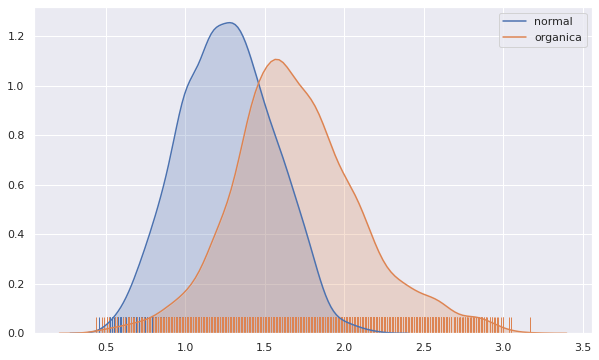

[1.47 1.45 1.43 ... 0.84 0.9  0.88]
[1.46 1.58 1.43 ... 1.87 1.93 1.62]
6098302785
216672176


In [270]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

##arreglos numpy
precios_paltas_normales = paltas_normales.Price.values#muestra paltas normales
precios_paltas_organicas = paltas_organicas.Price.values#muestra paltas orgánicas

total_ventas_paltas_normales = paltas_normales.TotalVolume.values#muestra paltas normales
total_ventas_paltas_organicas = paltas_organicas.TotalVolume.values#muestra paltas normales


f, ax = plt.subplots(1,1,figsize=(10,6))
sns.distplot(a=precios_paltas_normales, ax=ax, rug=True, hist=False, kde=True, kde_kws={"shade": True}, label = 'normal')
sns.distplot(a=precios_paltas_organicas, ax=ax, rug=True, hist=False, kde=True, kde_kws={"shade": True}, label = 'organica')
plt.show()

print(precios_paltas_normales)
print(precios_paltas_organicas)
print("%.d" % total_ventas_paltas_normales.sum())
print("%.d" % total_ventas_paltas_organicas.sum())

## **Desarrollo**

### **Pregunta 1**

> Primero, para poder abordar mejor esta pregunta y poder tener un hincapié inicial del problema a resolver, procederemos a obtener el valor esperado o promedio de los datos del precio de los tipos de palta, esto para poder ver si es suficiente esta información para obtener conclusiones acerca de estos datos.









In [271]:
#Promedio de paltas normales
promedio_normales = precios_paltas_normales.mean()

#Promedio paltas orgánicas
promedio_organicas = precios_paltas_organicas.mean()

print("El precio promedio de las paltas normales es de: $%.2f (sd=%.2f, n=%d)" % (promedio_normales,precios_paltas_normales.std(),len(precios_paltas_normales)))
print("El precio promedio de las paltas orgánicas es de: $%.2f (sd=%.2f, n=%d)" % (promedio_organicas,precios_paltas_organicas.std(),len(precios_paltas_organicas)))
print("\nEl intervalo de confianza para el valor esperado de las paltas normales es de: [%.10f, %.10f]" % (IC_media(precios_paltas_normales, alpha=0.05)[0],IC_media(precios_paltas_normales, alpha=0.05)[1]))
print("El intervalo de confianza para el valor esperado de las paltas orgánicas es de: [%.10f, %.10f]" % (IC_media(precios_paltas_organicas, alpha=0.05)[0],IC_media(precios_paltas_organicas, alpha=0.05)[1]))




El precio promedio de las paltas normales es de: $1.26 (sd=0.29, n=3508)
El precio promedio de las paltas orgánicas es de: $1.70 (sd=0.41, n=3508)

El intervalo de confianza para el valor esperado de las paltas normales es de: [1.2545551533, 1.2740195331]
El intervalo de confianza para el valor esperado de las paltas orgánicas es de: [1.6909702207, 1.7178781260]


> Esto nos dice a primera vista, que el precio promedio de las paltas orgánicas es mas caro que el precio promedio de las paltas normales. Sin embargo, no es suficiente para concluir con certeza que efectivamente lo anterior es cierto. Esto se debe a que lo que tenemos es una muestra de los datos, y no la población completa. **Es decir, si obtenemos datos al azar de la muestra, y sacamos las medias de estas sub-muestras, darán medias distintas, por lo que los valores obtenidos anteriormente no son representativos del todo**. 


### **Pregunta 2**

> Ahora, procederemos a construir el I.C para la diferencia de precios de las paltas, esto para obtener una mejor representación acerca de cuál de éstas paltas resulta ser, en efecto, mas cara. Finalmente, sabemos que un intervalo de confianza para la diferencia de dos poblaciones, con nivel de confianza $1-\alpha$ está dado por:

\begin{align*}
IC=\left[\bar{X} - \bar{Y} \pm T_{\alpha/2,v}\sqrt{\frac{S_x^2}{n_x} + \frac{S_y^2}{n_y}}\right]
\end{align*}

> entonces utilizando las dos muestras anteriores, obtenemos lo siguiente:




El I.C para la diferencia de las medias es de: [0.4262043058, 0.4540693544] (alfa = 0.100000) 
El I.C para la diferencia de las medias es de: [0.4235344653, 0.4567391949] (alfa = 0.050000) 
El I.C para la diferencia de las medias es de: [0.4227397803, 0.4575338799] (alfa = 0.040000) 
El I.C para la diferencia de las medias es de: [0.4217539127, 0.4585197475] (alfa = 0.030000) 
El I.C para la diferencia de las medias es de: [0.4204297076, 0.4598439526] (alfa = 0.020000) 
El I.C para la diferencia de las medias es de: [0.4183152382, 0.4619584220] (alfa = 0.010000) 
El I.C para la diferencia de las medias es de: [0.4163553902, 0.4639182700] (alfa = 0.005000) 
El I.C para la diferencia de las medias es de: [0.4157524017, 0.4645212585] (alfa = 0.004000) 
El I.C para la diferencia de las medias es de: [0.4149929769, 0.4652806833] (alfa = 0.003000) 
El I.C para la diferencia de las medias es de: [0.4139543953, 0.4663192649] (alfa = 0.002000) 
El I.C para la diferencia de las medias es de: [0.

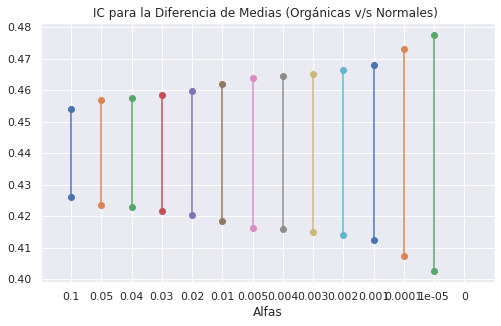

In [281]:
f = plt.figure(figsize=(7,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])

alfas = [0.1,0.05,0.04,0.03,0.02,0.01,0.005,0.004,0.003,0.002,0.001,0.0001,0.00001,0]
for idx,alfa in enumerate(alfas):
    print("El I.C para la diferencia de las medias es de: [%.10f, %.10f] (alfa = %.6f) " % (IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[0],IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[1],alfa))
    ax.plot([idx,idx],[IC_dos_medias_hetero(precios_paltas_organicas,precios_paltas_normales,alpha=alfa)[0],IC_dos_medias_hetero(precios_paltas_organicas,precios_paltas_normales,alpha=alfa)[1]],'o-')

ax.set_xlim(-1,len(alfas))
ax.set_xticks(np.arange(0,len(alfas)+.5,1))
ax.set_xticklabels(alfas)
ax.set_xlabel("Alfas")
ax.set_title("IC para la Diferencia de Medias (Orgánicas v/s Normales) ")

plt.show()

### **Pregunta 3**

> Utilizando ahora, $\frac{1}{10}$ de los $n$ datos de la muestra ($n=3508$) procedemos análogamente a la pregunta 1 y 2.

In [291]:
muestra_pequeña_normales = np.random.choice(precios_paltas_normales, size=int(1/10 * len(precios_paltas_normales)), replace=False) #sub-muestra normales
muestra_pequeña_organicas = np.random.choice(precios_paltas_organicas, size=int(1/10 * len(precios_paltas_organicas)), replace=False) #sub-muestra organicas

#Promedio de sub-muestra normales
promedio_muestra_normales = muestra_pequeña_normales.mean()

#Promedio de sub-muestra orgánicas
promedio_muestra_organicas = muestra_pequeña_organicas.mean()

print("El precio promedio de las paltas normales es de: $%.2f (sd=%.2f, n=%d)" % (promedio_muestra_normales,muestra_pequeña_normales.std(),len(muestra_pequeña_normales)))
print("El precio promedio de las paltas orgánicas es de: $%.2f (sd=%.2f, n=%d)" % (promedio_muestra_organicas,muestra_pequeña_organicas.std(),len(muestra_pequeña_organicas)))

print("\nEl intervalo de confianza para el valor esperado de las paltas normales es de: [%.10f, %.10f]" % (IC_media(muestra_pequeña_normales, alpha=0.05)[0],IC_media(precios_paltas_normales, alpha=0.05)[1]))
print("El intervalo de confianza para el valor esperado de las paltas orgánicas es de: [%.10f, %.10f]" % (IC_media(muestra_pequeña_organicas, alpha=0.05)[0],IC_media(precios_paltas_organicas, alpha=0.05)[1]))


El precio promedio de las paltas normales es de: $1.27 (sd=0.28, n=350)
El precio promedio de las paltas orgánicas es de: $1.70 (sd=0.41, n=350)

El intervalo de confianza para el valor esperado de las paltas normales es de: [1.2407815866, 1.2740195331]
El intervalo de confianza para el valor esperado de las paltas orgánicas es de: [1.6543344087, 1.7178781260]


El I.C para la diferencia de las medias es de: [0.3919624841, 0.4943232302] (alfa = 0.05000) 
El I.C para la diferencia de las medias es de: [0.3895052782, 0.4967804361] (alfa = 0.04000) 
El I.C para la diferencia de las medias es de: [0.3864554727, 0.4998302416] (alfa = 0.03000) 
El I.C para la diferencia de las medias es de: [0.3823563279, 0.5039293864] (alfa = 0.02000) 
El I.C para la diferencia de las medias es de: [0.3758039867, 0.5104817276] (alfa = 0.01000) 
El I.C para la diferencia de las medias es de: [0.3697225288, 0.5165631854] (alfa = 0.00500) 
El I.C para la diferencia de las medias es de: [0.3678497259, 0.5184359883] (alfa = 0.00400) 
El I.C para la diferencia de las medias es de: [0.3654898493, 0.5207958650] (alfa = 0.00300) 
El I.C para la diferencia de las medias es de: [0.3622602631, 0.5240254512] (alfa = 0.00200) 
El I.C para la diferencia de las medias es de: [0.3569729945, 0.5293127198] (alfa = 0.00100) 
El I.C para la diferencia de las medias es de: [0.3410798526

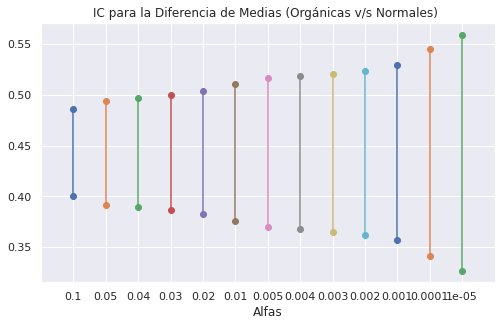

In [283]:
alfas = [0.05,0.04,0.03,0.02,0.01,0.005,0.004,0.003,0.002,0.001,0.0001,0.00001]
for alfa in alfas:
    print("El I.C para la diferencia de las medias es de: [%.10f, %.10f] (alfa = %.5f) " % (IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[0],IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[1],alfa))

f = plt.figure(figsize=(7,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])

alfas = [0.1,0.05,0.04,0.03,0.02,0.01,0.005,0.004,0.003,0.002,0.001,0.0001,0.00001]
for idx,alfa in enumerate(alfas):
    # print("\nEl I.C para la diferencia de las medias es de: [%.10f, %.10f] (alfa = %.5f) " % (IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[0],IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[1],alfa))
    ax.plot([idx,idx],[IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[0],IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[1]],'o-')

ax.set_xlim(-1,len(alfas))
ax.set_xticks(np.arange(0,len(alfas)+.5,1))
ax.set_xticklabels(alfas)
ax.set_xlabel("Alfas")
ax.set_title("IC para la Diferencia de Medias (Orgánicas v/s Normales) ")

plt.show()


> Observando lo anterior, notemos que los resultados siguen siendo consistentes con lo obtenido en las preguntas 1 y 2 aún así teniendo una muestra aleatoria del 10% del total de los datos. Esto puede deberse probablemente porque nuestra muestra inicial de $n=3508$ elementos es un "buen" número de muestras por así decir, es decir que la cantidad de datos no es pobre. Luego, si bien el 10% de estos datos, siendo $n'\approx$  350, es una muestra mucho más pobre, arroja resultados consistentes con lo anterior, claramente con una variabilidad en los I.C resultantes presente, pero al fin y al cabo demostrando que incluso para niveles de significación muy pequeños ($\alpha=0.00001$) la diferencia de precios de paltas orgánicas y normales sigue siendo positiva , y esto se debe a que se escogen los datos aleatoriamente, y por lo tanto, se obtienen distintas sub-muestras, las cuáles pueden ser más buenas o más malas que la muestra original.



El I.C para la diferencia de las medias es de: [0.3385215173, 0.4857070541] (alfa = 0.05000 n = 175) 
El I.C para la diferencia de las medias es de: [0.3532875083, 0.4575124917] (alfa = 0.05000 n = 350) 
El I.C para la diferencia de las medias es de: [0.3979691456, 0.4730722239] (alfa = 0.05000 n = 701) 
El I.C para la diferencia de las medias es de: [0.4126451726, 0.4723928502] (alfa = 0.05000 n = 1052) 
El I.C para la diferencia de las medias es de: [0.4173045218, 0.4641435968] (alfa = 0.05000 n = 1754) 
El I.C para la diferencia de las medias es de: [0.4168379911, 0.4567506036] (alfa = 0.05000 n = 2455) 
El I.C para la diferencia de las medias es de: [0.4235344653, 0.4567391949] (alfa = 0.05000 n = 3508) 


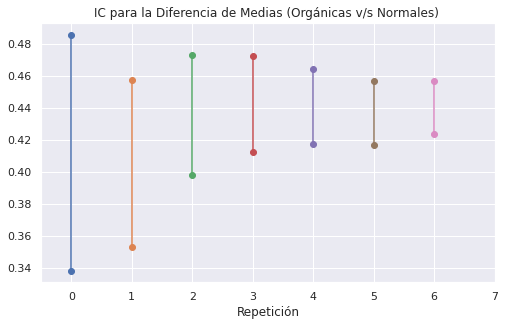

In [294]:
f = plt.figure(figsize=(7,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])
alfa = 0.05
size_muestra = 3508
enes = [0.05 * size_muestra, 0.1 * size_muestra,0.2 * size_muestra,0.3 * size_muestra,0.5 * size_muestra,0.7 * size_muestra,size_muestra]
for idx,n in enumerate(enes):
    muestra_pequeña_normales = np.random.choice(precios_paltas_normales, size=int(n), replace=False) #sub-muestra normales
    muestra_pequeña_organicas = np.random.choice(precios_paltas_organicas, size=int(n), replace=False) #sub-muestra organicas
    print("El I.C para la diferencia de las medias es de: [%.10f, %.10f] (alfa = %.5f n = %.d) " % (IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[0],IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[1],alfa,n))
    ax.plot([idx,idx],[IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[0],IC_dos_medias_hetero(muestra_pequeña_organicas,muestra_pequeña_normales,alpha=alfa)[1]],'o-')

ax.set_xlim(-0.5,len(enes))
# ax.set_xticks(np.arange(0,len(enes)+.5,1))
ax.set_xlabel("Repetición")
ax.set_title("IC para la Diferencia de Medias (Orgánicas v/s Normales) ")

plt.show()

## **2: Los Angeles versus New York**

La rivalidad y la diferencia de estilo de vida entre estas dos ciudades ha sido retratada en múltiples mini-series y películas. Es natural entonces preguntarse
dónde tiene más oportunidades de prosperar un "Millenial" amante de las paltas. Más específicamente, 

> **¿Es más cara la palta en Los Ángeles (LA) o en Nueva York (NY)?**

Elabore una conclusión ejecutando las siguientes actividades:

1.   Construya un I.C. que de cuenta de la diferencia de precios entre ambas ciudades. ¿Es posible afirmar que se pagará al menos 20 centésimos de dólar más por una palta en NY? Determine para qué nivel de significación esa conclusión ya no se puede obtener. Comente. 

2.   Construya un I.C. para comparar la varianza de los precios en ambas ciudades. ¿Es más variable el precio en alguna de las dos ciudades?

El código de acá abajo prepara arreglos numpy con todas las observaciones de que se dispone para NY y LA.

Por favor separe el análisis de paltas orgánicas y normales.


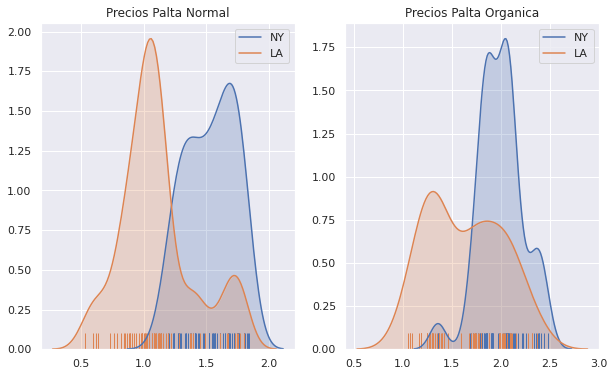

In [276]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

precios_NY_normal = paltas_normales.loc[paltas_normales.region == 'NewYork'].Price.values
precios_LA_normal = paltas_normales.loc[paltas_normales.region == 'LosAngeles'].Price.values              
precios_NY_organica = paltas_organicas.loc[paltas_organicas.region == 'NewYork'].Price.values
precios_LA_organica = paltas_organicas.loc[paltas_organicas.region == 'LosAngeles'].Price.values              

f, ax = plt.subplots(1,2,figsize=(10,6))
sns.distplot(precios_NY_normal, ax=ax[0], rug=True, hist=False, kde=True, kde_kws={"shade": True}, label = 'NY')
sns.distplot(precios_LA_normal, ax=ax[0], rug=True, hist=False, kde=True, kde_kws={"shade": True}, label = 'LA')
ax[0].set_title("Precios Palta Normal")
sns.distplot(precios_NY_organica, ax=ax[1], rug=True, hist=False, kde=True, kde_kws={"shade": True}, label = 'NY')
sns.distplot(precios_LA_organica, ax=ax[1], rug=True, hist=False, kde=True, kde_kws={"shade": True}, label = 'LA')
ax[1].set_title("Precios Palta Organica")
plt.show()


## **Desarrollo**

### **Pregunta 1**

> Para esta pregunta se utilizará un aproach estilo fuerza bruta, probando intervalos de confianza para dos medias heterocedásticas, en donde se irá variando el nivel de significancia $\alpha$ desde $0.1$ hasta $0.001$.

> Para una mejor visualización de los datos se realizará un gráfico para las paltas normales y otro para las paltas orgánicas.








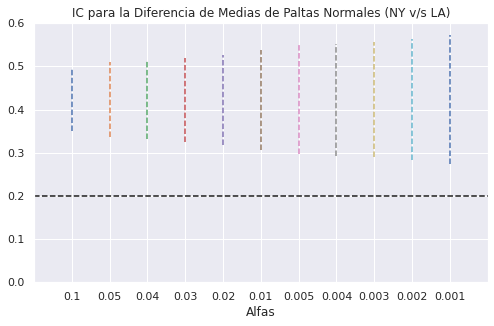

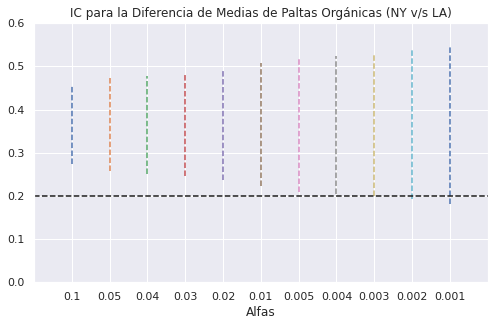

In [277]:
f = plt.figure(figsize=(7,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])

f = plt.figure(figsize=(7,4))
bx = f.add_axes([0.1, 0.1, 0.9, 0.9])

alfas = [0.10,0.05,0.04,0.03,0.02,0.01,0.005,0.004,0.003,0.002,0.001]

#I.C paltas normales
for  idx,alfa in enumerate(alfas):
    ax.plot([idx,idx],[IC_dos_medias_hetero(precios_NY_normal,precios_LA_normal,alpha=alfa)[0],IC_dos_medias_hetero(precios_NY_normal,precios_LA_normal,alpha=alfa)[1]],'--')
print("")
#I.C paltas organicas
for idx,alfa in enumerate(alfas):
    bx.plot([idx,idx],[IC_dos_medias_hetero(precios_NY_organica,precios_LA_organica,alpha=alfa)[0],IC_dos_medias_hetero(precios_NY_organica,precios_LA_organica,alpha=alfa)[1]],'--')

valor = 0.20

ax.plot([-1,len(alfas)],[valor,valor],'--',color='k')

ax.set_xlim(-1 ,len(alfas))
ax.set_ylim(0,0.60)
ax.set_xlabel("Alfas")
ax.set_xticks(np.arange(0,len(alfas)+.5,1))
ax.set_xticklabels(alfas)
ax.set_title("IC para la Diferencia de Medias de Paltas Normales (NY v/s LA)")

bx.plot([-1,len(alfas)],[valor,valor],'--',color='k')

bx.set_xlim(-1 ,len(alfas))
bx.set_ylim(0,0.60)
bx.set_xlabel("Alfas")
bx.set_xticks(np.arange(0,len(alfas)+.5,1))
bx.set_xticklabels(alfas)
bx.set_title("IC para la Diferencia de Medias de Paltas Orgánicas (NY v/s LA)")

plt.show()

> Analizando lo obtenido en los gráficos, notemos que, para los I.C para la diferencia de las media de las paltas normales de cada ciudad, ningún valor estuvo bajo los $20$ céntimos, no así como en el gráfico para las paltas orgánicas, el cual si nos fijamos, los ultimos tres I.C terminan pasando la barrera de los $20$ céntimos, por lo tanto, podemos concluir que para niveles de significancia aproximados a $\alpha \leq 0.003$, ya no podemos afirmar que se pagará menos $20$ centésimos de dólar por una palta en NY.


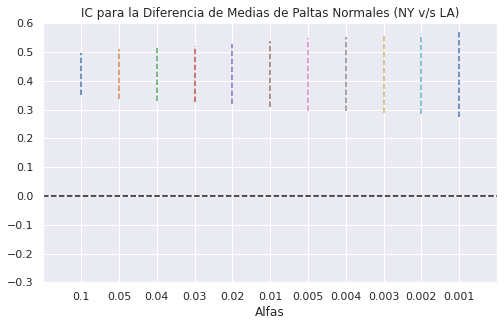

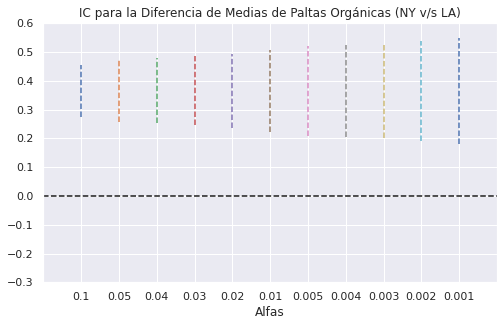

In [298]:
f = plt.figure(figsize=(7,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])

f = plt.figure(figsize=(7,4))
bx = f.add_axes([0.1, 0.1, 0.9, 0.9])

alfas = [0.10,0.05,0.04,0.03,0.02,0.01,0.005,0.004,0.003,0.002,0.001]

#I.C paltas normales
for  idx,alfa in enumerate(alfas):
    ax.plot([idx,idx],[IC_dos_medias_hetero(precios_NY_normal,precios_LA_normal,alpha=alfa)[0],IC_dos_medias_hetero(precios_NY_normal,precios_LA_normal,alpha=alfa)[1]],'--')
print("")
#I.C paltas organicas
for idx,alfa in enumerate(alfas):
    bx.plot([idx,idx],[IC_dos_medias_hetero(precios_NY_organica,precios_LA_organica,alpha=alfa)[0],IC_dos_medias_hetero(precios_NY_organica,precios_LA_organica,alpha=alfa)[1]],'--')

valor = 0.0

ax.plot([-1,len(alfas)],[valor,valor],'--',color='k')

ax.set_xlim(-1 ,len(alfas))
ax.set_ylim(-0.3,0.60)
ax.set_xlabel("Alfas")
ax.set_xticks(np.arange(0,len(alfas)+.5,1))
ax.set_xticklabels(alfas)
ax.set_title("IC para la Diferencia de Medias de Paltas Normales (NY v/s LA)")

bx.plot([-1,len(alfas)],[valor,valor],'--',color='k')

bx.set_xlim(-1 ,len(alfas))
bx.set_ylim(-0.3,0.60)
bx.set_xlabel("Alfas")
bx.set_xticks(np.arange(0,len(alfas)+.5,1))
bx.set_xticklabels(alfas)
bx.set_title("IC para la Diferencia de Medias de Paltas Orgánicas (NY v/s LA)")

plt.show()

### **Pregunta 2**


El I.C de la varianza de los precios de las paltas normales en LA es: [0.064075441948941, 0.128812695640375]
El I.C de la varianza de los precios de las paltas normales en NY es: [0.028052135216813, 0.056394010651153]
El I.C de la varianza de los precios de las paltas orgánicas en LA es: [0.102647722250291, 0.206355655181291]
El I.C de la varianza de los precios de las paltas orgánicas en NY es: [0.037308492324928, 0.075002330385512]


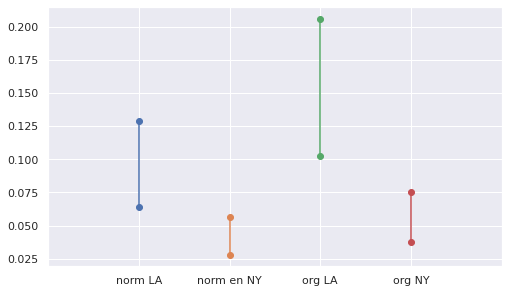

In [279]:
ic_varianza_normales_LA = IC_varianza(precios_LA_normal,alpha=0.05)
ic_varianza_normales_NY = IC_varianza(precios_NY_normal,alpha=0.05)
ic_varianza_organicas_LA = IC_varianza(precios_LA_organica,alpha=0.05)
ic_varianza_organicas_NY = IC_varianza(precios_NY_organica,alpha=0.05)

print("El I.C de la varianza de los precios de las paltas normales en LA es: [%.15f, %.15f]" % (ic_varianza_normales_LA[0],ic_varianza_normales_LA[1]))
print("El I.C de la varianza de los precios de las paltas normales en NY es: [%.15f, %.15f]" % (ic_varianza_normales_NY[0],ic_varianza_normales_NY[1]))
print("El I.C de la varianza de los precios de las paltas orgánicas en LA es: [%.15f, %.15f]" % (ic_varianza_organicas_LA[0],ic_varianza_organicas_LA[1]))
print("El I.C de la varianza de los precios de las paltas orgánicas en NY es: [%.15f, %.15f]" % (ic_varianza_organicas_NY[0],ic_varianza_organicas_NY[1]))

f = plt.figure(figsize=(7,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])

ax.plot([1,1],[ic_varianza_normales_LA[0],ic_varianza_normales_LA[1]],'o-')
ax.plot([2,2],[ic_varianza_normales_NY[0],ic_varianza_normales_NY[1]],'o-')
ax.plot([3,3],[ic_varianza_organicas_LA[0],ic_varianza_organicas_LA[1]],'o-')
ax.plot([4,4],[ic_varianza_organicas_NY[0],ic_varianza_organicas_NY[1]],'o-')

ax.set_xlim(0,5)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(["norm LA","norm en NY","org LA","org NY"])
plt.show()



> Analizando el gráfico anterior, notemos que los límites de los I.C para las paltas de LA son superiores y casi ni se solapan junto con los de NY, solo un poco las paltas normales de LA con las orgánicas de NY. Aún así, se nota una una mayor variabilidad de los datos por parte de las LA.


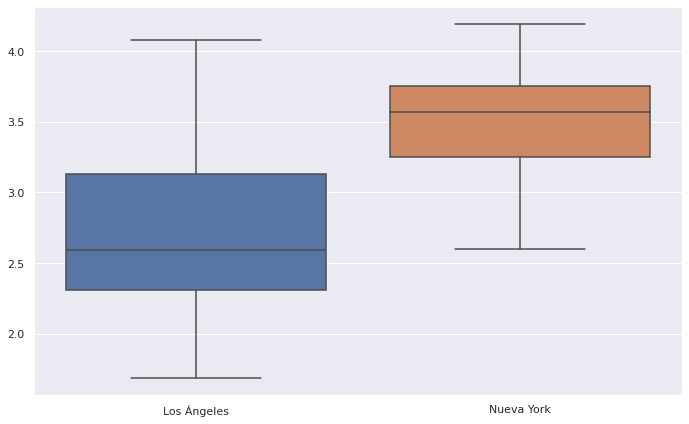

In [280]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
f = plt.figure(figsize=(10,6))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])

precios_total_LA = precios_LA_normal + precios_LA_organica
precios_total_NY = precios_NY_normal + precios_NY_organica

sns.boxplot(data=[precios_total_LA, precios_total_NY])
ax.set_xticks([0,1])
ax.set_xticklabels(["Los Ángeles","Nueva York"])

plt.show()

## Conclusiones

> **¿Vale la pena producir una palta orgánica?**
>> De acuerdo a los resultados en la Pregunta 1.2, y basándonos en los análisis realizados anteriormente, podemos concluir con bastante seguridad que si es bastante rentable el producir palta orgánica, ya que la diferencia de las medias de los precios de las paltas orgánicas v/s normales eran significativamente mayor a cero, por lo que aunque se probasen niveles significación de menos del 1%, se seguiría manteniendo lo anterior.

> **¿Es más cara la palta en Los Ángeles (LA) o en Nueva York (NY)?**
>> Comparando los resultados obtenidos en la Pregunta 2.1, podemos concluir que la palta no es más cara en LA, sino que en NY, esto debido a que la comparación de I.C de las diferencias medias de las de paltas normales y orgánicas de las ciudades fueron ligeramente mayor a cero, indicante que la palta es más cara en NY que en LA, aún para niveles de significación ridículamente pequeños ($0.000001$)


[**Link al video explicativo** ](https://drive.google.com/file/d/1ttsBPRBO2Fu-YKite9UoNIGaUrghjyMH/view?usp=sharing)



